# Identifying Hummingbird Species of the Rocky Mountains

*Adapted from FastAI v4, Course 2*


Audubon [observes the following](https://rockies.audubon.org/blog/habitat-hero/backyard-hummingbirds
) about hummingbird species in the Rockies:

> In Wyoming and Colorado there are four main species that you will see. Broad-tailed (Selasphorus platycercus) and Rufous (Selasphorous rufus) Hummingbirds are the most common you will probably see. Less common species are the Calliope (Selasphorus calliope) and Black-chinned (Archilochus alexandri) Hummingbirds.

|  |  |  |  |
|---|---|---|---|
| ![]( https://nas-national-prod.s3.amazonaws.com/styles/bird_illustration/s3/2735_Sibl_9780307957900_art_r1.jpg?itok=m1TzaJDi ) | ![]( https://nas-national-prod.s3.amazonaws.com/styles/bird_illustration/s3/2747_Sibl_9780307957900_art_r1.jpg?itok=LXCr5qsa ) | ![]( https://nas-national-prod.s3.amazonaws.com/styles/bird_illustration/s3/2760_Sibl_9780307957900_art_r1.jpg?itok=pnOj0j9q ) | ![]( https://nas-national-prod.s3.amazonaws.com/styles/bird_illustration/s3/2733_Sibl_9780307957900_art_r1.jpg?itok=kM3iVfa8 ) |


In [1]:
#hide
# !pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [2]:
#hide
from fastbook import *
from fastai.vision.widgets import *

In [3]:
key = os.environ.get('AZURE_SEARCH_KEY', 'WXYZ')

In [4]:
search_images_bing

<function fastbook.search_images_bing(key, term, min_sz=128, max_images=150)>

In [5]:
results = search_images_bing(key, 'rufous hummingbird')
ims = results.attrgot('content_url')
len(ims)

150

In [6]:
#hide
ims = ['https://upload.wikimedia.org/wikipedia/commons/thumb/f/ff/Selasphorus_rufus_on_Saltspring_Island.jpg/1024px-Selasphorus_rufus_on_Saltspring_Island.jpg']

In [7]:
dest = 'images/rufous.jpg'
download_url(ims[0], dest)

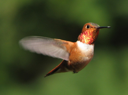

In [8]:
im = Image.open(dest)
im.to_thumb(128,128)

In [9]:
hummingbird_types = 'broad-tailed','rufous','calliope','black-chinned'
path = Path('hummingbirds')

In [10]:
if not path.exists():
    path.mkdir()
    for o in hummingbird_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o} hummingbird')
        download_images(dest, urls=results.attrgot('contentUrl'))

In [11]:
fns = get_image_files(path)
fns

(#561) [Path('hummingbirds/calliope/00000126.jpg'),Path('hummingbirds/calliope/00000077.jpg'),Path('hummingbirds/calliope/00000039.jpg'),Path('hummingbirds/calliope/00000083.jpg'),Path('hummingbirds/calliope/00000124.jpg'),Path('hummingbirds/calliope/00000029.jpg'),Path('hummingbirds/calliope/00000040.jpg'),Path('hummingbirds/calliope/00000059.jpg'),Path('hummingbirds/calliope/00000014.jpg'),Path('hummingbirds/calliope/00000010.jpg')...]

In [12]:
failed = verify_images(fns)
failed

(#1) [Path('hummingbirds/broad-tailed/00000069.jpg')]

In [13]:
failed.map(Path.unlink);

In [14]:
hummingbirds = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [15]:
dls = hummingbirds.dataloaders(path)

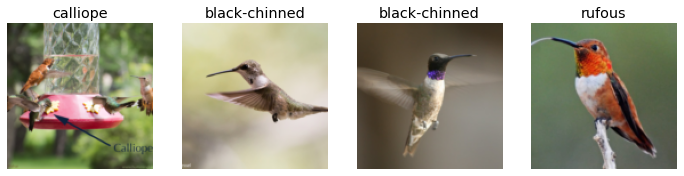

In [16]:
dls.valid.show_batch(max_n=4, nrows=1)

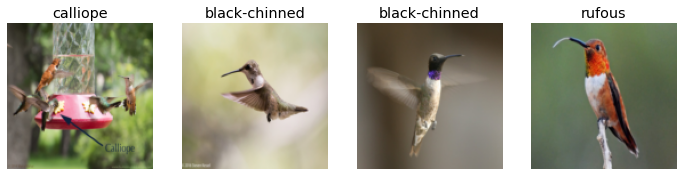

In [17]:
hummingbirds = hummingbirds.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = hummingbirds.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

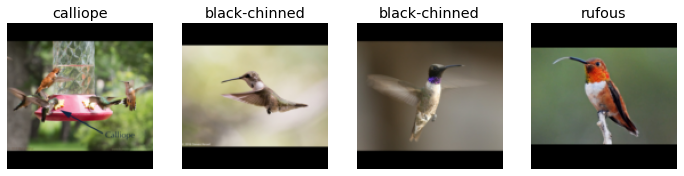

In [18]:
hummingbirds = hummingbirds.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = hummingbirds.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

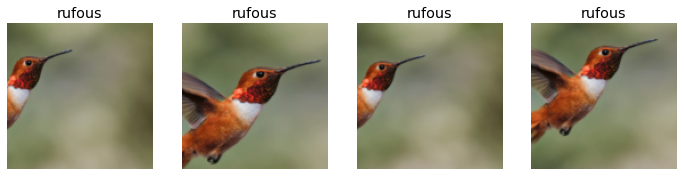

In [19]:
hummingbirds = hummingbirds.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = hummingbirds.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

### Data Augmentation

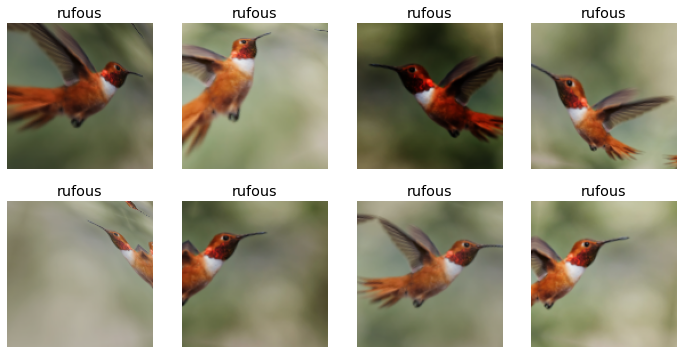

In [20]:
hummingbirds = hummingbirds.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = hummingbirds.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [21]:
hummingbirds = hummingbirds.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = hummingbirds.dataloaders(path, bs=16)

In [22]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,2.106555,1.038512,0.303571,00:13


epoch,train_loss,valid_loss,error_rate,time
0,1.069859,0.834275,0.285714,00:17
1,1.014945,0.882452,0.267857,00:17
2,0.835172,0.757465,0.267857,00:17
3,0.624683,0.688332,0.223214,00:17


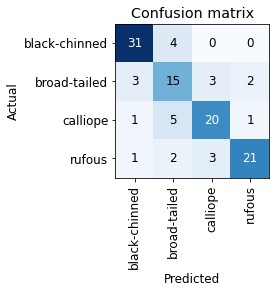

In [23]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

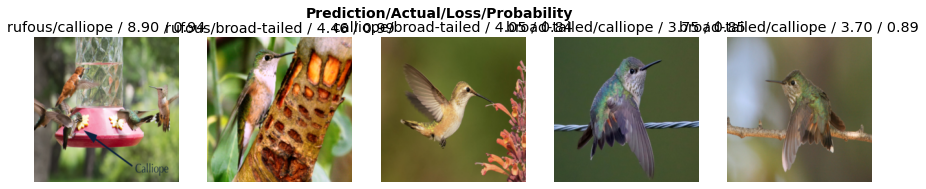

In [24]:
interp.plot_top_losses(5, nrows=1)

In [25]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [26]:
#hide
# for idx in cleaner.delete(): cleaner.fns[idx].unlink()
# for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

## Turning Your Model into an Online Application

### Using the Model for Inference

In [27]:
learn.export()

In [28]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [29]:
learn_inf = load_learner(path/'export.pkl')

In [30]:
learn_inf.predict('images/rufous.jpg')

('rufous', tensor(3), tensor([8.7440e-06, 9.0223e-04, 4.8574e-06, 9.9908e-01]))

In [31]:
learn_inf.dls.vocab

['black-chinned', 'broad-tailed', 'calliope', 'rufous']

### Creating a Notebook App from the Model

In [32]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [34]:
#hide
# For the book, we can't actually click an upload button, so we fake it
btn_upload = SimpleNamespace(data = ['images/rufous.jpg'])

In [35]:
img = PILImage.create(btn_upload.data[-1])

In [36]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [37]:
pred,pred_idx,probs = learn_inf.predict(img)

In [38]:
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: rufous; Probability: 0.9991')

In [39]:
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [40]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [41]:
#hide
#Putting back btn_upload to a widget for next cell
btn_upload = widgets.FileUpload()

In [42]:
VBox([widgets.Label('Select your bird!'), 
      btn_upload, btn_run, out_pl, lbl_pred])